# Magma 
Showing magma substructures

In [17]:
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import cairosvg
import io

In [18]:
from mist.utils import plot_utils
# Reload plot_utils
import importlib
importlib.reload(plot_utils)

from mist.magma import fragmentation

In [3]:
plot_utils.set_style()

In [4]:
input_dir = "../data/paired_spectra/canopus_train/"
input_dir = Path(input_dir)
magma_dir = input_dir / "magma_outputs/magma_tsv/"
labels_file = input_dir / "labels.tsv"
k = 6
date = datetime.now().strftime("%Y_%m_%d")
res_dir = f"../results/figures/magma/"
res_dir_orig = Path(res_dir)
res_dir_orig.mkdir(exist_ok=True, parents=True)

In [5]:
name_to_full_smi = dict(pd.read_csv(labels_file, sep="\t")[['spec', 'smiles']].values)
magma_files = list(magma_dir.glob("*.magma"))

In [6]:
f1 = magma_files[0]
!head -n 20  $f1

mz_observed	mz_corrected	inten	ppm_diff	frag_inds	frag_mass	frag_h_shift	frag_base_form	frag_hashes	frag_fp
133.051773	115.017947452	0.05732035715480026	3.8451738167619873	274879087544	115.018389716	3	C8OH6	ce3eb6e2b9d63e354725f1df42a86a75c8e7712e1959445f871e7ace51e68742	94,170,254,281,468,596,972,1078,1173,1423,1435,1436,1676,1977,2036
231.090149	213.056323452	0.0685751296871283	5.417834970958897	158604721292282	213.055169148	3	C13O3H12	2b48dd73d183807a15ac610628fa7b50ca58ffb149de0f14d7f0aef4973aedd1	281,314,319,468,583,835,901,931,1241,1257,1328,1435,1559,1616,1651,1798,1866,1880,1975,1977,2036
740.277222	722.2433964520001	0.14522257001434505	1.6567378884900414	2251799813685247	722.2421998840005	6	C34O17H42	e7c48f58ab868c7fd45f06eb803673b085e31b94d0f7108646b9c9259f859455	14,19,104,126,150,181,281,297,308,314,319,450,462,468,523,835,866,901,906,950,1039,1115,1128,1154,1166,1167,1215,1241,1249,1328,1353,1410,1412,1435,1448,1455,1463,1559,1616,1735,1798,1815,1832,1866,1880,1908,1977,198

In [20]:
# Choose a spectrum
ind = np.random.choice(len(magma_files))
temp_file = magma_files[ind]

# Load in data
spec_name = temp_file.stem
res_dir = res_dir_orig / spec_name
spec_smiles = name_to_full_smi.get(spec_name)
engine = fragmentation.FragmentEngine(spec_smiles,)


# Process magma file
magma_input = pd.read_csv(temp_file, sep="\t")
frag_hashes, mzs, intens = zip(*magma_input[['frag_hashes', 'mz_observed', "inten"]].values)
#magma_input.keys()

mzs = np.array(mzs)
intens = np.array(intens) / np.max(intens)
frag_hashes = np.array(frag_hashes)
top_intens = np.sort(intens)[::-1][:k]

In [21]:
engine.generate_fragments()

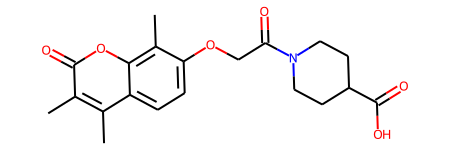

In [22]:
mol = Chem.MolFromSmiles(spec_smiles)
mol

In [23]:
hash = frag_hashes[0]
draw_dict = engine.get_draw_dict(engine.frag_to_entry[hash]['frag'])
draw_dict 

{'hatoms': [0, 1, 10, 11, 19, 24, 26],
 'hbonds': [0, 1, 14, 16, 27, 28],
 'mol': <rdkit.Chem.rdchem.Mol at 0x7fb3f7a8e580>,
 'smiles': 'Cc1c(C)c2ccc(OCC(=O)N3CCC(C(=O)O)CC3)c(C)c2oc1=O'}

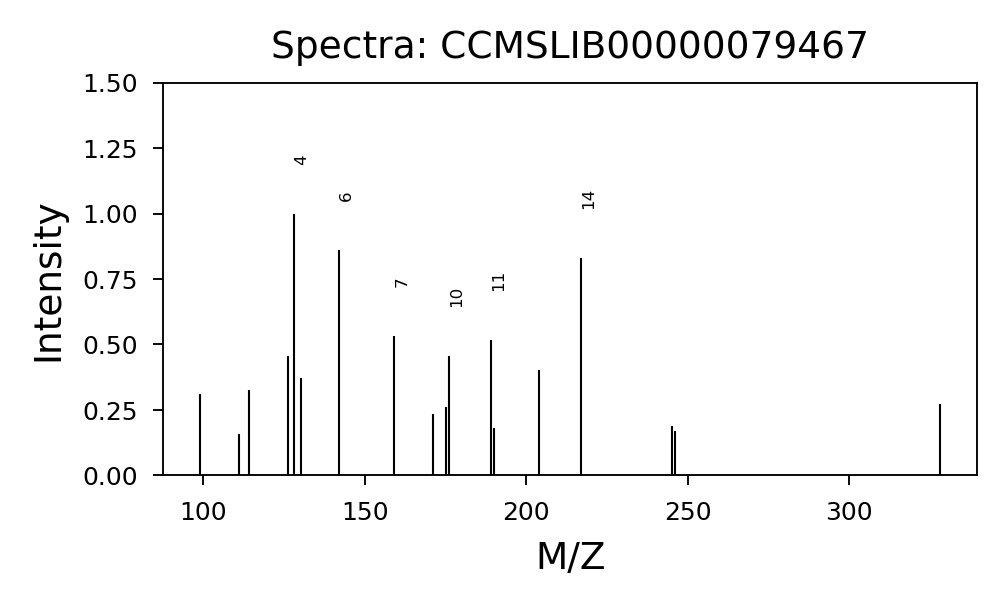

In [27]:
# Create plot
fig = plt.figure(figsize=(3.5,1.7), dpi=300)
ax = fig.gca()
full_out_smi = res_dir / f"{spec_name}_mol_full.pdf"
full_out_smi.parent.mkdir(exist_ok=True, parents=True)

mol = engine.mol
Chem.Kekulize(mol)
plot_utils.export_mol(mol, full_out_smi, )
for ind, (hash_val, (m, i)) in enumerate(zip(frag_hashes, zip(mzs, intens))): 
    ax.vlines(x=m, ymin=0,ymax=i, color="black", linewidth=0.5)
    if hash_val is not None and i in top_intens:
        draw_dict = engine.get_draw_dict(engine.frag_to_entry[hash_val]['frag'])
        hatoms = draw_dict['hatoms']
        hbonds = draw_dict['hbonds']
        ax.text(x=m, y=i + 0.2, s = f"{ind}", fontsize=4, rotation=90) 
        temp_out_smi = res_dir / f"{spec_name}_mol_{ind}.pdf"
        plot_utils.export_mol(mol, temp_out_smi, highlight_atoms=hatoms, highlight_bonds=hbonds, height=400, width=400)

ax.set_xlabel("M/Z")
ax.set_ylabel("Intensity")
ax.set_ylim([0, 1.5])
ax.set_title(f"Spectra: {spec_name}")
plt.savefig(res_dir / f"{spec_name}_out_spec.pdf", bbox_inches="tight")